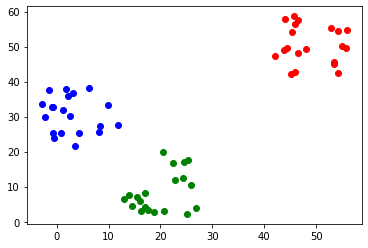

In [2]:
import math
import numpy as np
import pandas as pd
np.random.seed(123)

#Generating random sample data
def circulo(num_datos = 100,R = 1, minimo = 0,maximo= 1, center_x = 0 , center_y = 0):
    pi = math.pi
    r = R * np.sqrt(np.random.uniform(minimo, maximo, size = num_datos)) 
    theta = np.random.uniform(minimo, maximo, size= num_datos) * 2 * pi

    x = center_x + np.cos(theta) * r
    y = center_y + np.sin(theta) * r

    x = np.round(x,3)
    y = np.round(y,3)

    df = np.column_stack([x,y])
    df = pd.DataFrame(df)
    df.columns = ['x','y']
    return(df)

# Create data
datos_1 = circulo(num_datos = 20,R = 10, center_x = 5, center_y = 30)
datos_2 = circulo(num_datos = 20,R = 10, center_x = 20, center_y = 10)
datos_3 = circulo(num_datos = 20,R = 10, center_x = 50, center_y = 50)

data = datos_1.append(datos_2).append(datos_3)
#data1.head()

#Plotting the sample data
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(datos_1['x'],datos_1['y'],c='b')
plt.scatter(datos_2['x'],datos_2['y'],c='g')
plt.scatter(datos_3['x'],datos_3['y'],c='r')
plt.show()



In [7]:
#Importing the data file
gen_data=pd.read_csv('C:\\Users\\bindu\\OneDrive\\Documents\\BioInformatics\\CASP.csv')
gen_data.head()


def gen_centroids(k, gen_data):

    dim = gen_data.shape[1]
    centroid_min = gen_data.min().min()
    centroid_max = gen_data.max().max()
    centroids = []

    for i in range(k):
        i = np.random.uniform(centroid_min, centroid_max, dim)
        centroids.append(i)

    centroids = pd.DataFrame(centroids, columns = gen_data.columns)

    return centroids

centroids = gen_centroids(3, gen_data)
centroids



,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,3.287029e+06,4.738020e+06,5.381841e+06,4.342905e+05,2.343921e+06,1.119261e+06,2.465888e+06,2.997369e+06,5.106848e+05,1.624426e+06
1,5.075752e+06,3.113595e+06,2.502964e+06,4.123303e+06,4.059478e+06,2.658250e+05,3.878000e+06,4.592349e+06,9.080140e+05,4.273630e+06
2,1.567932e+06,1.677006e+06,3.640318e+06,6.095392e+05,3.638190e+06,4.858362e+06,3.810223e+06,2.409479e+06,2.397914e+06,4.186615e+06


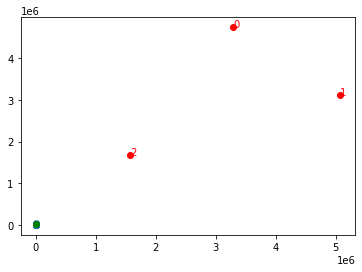

In [8]:
def calculate_error(a,b):
    #Calculating the sum of squared errors
    error = np.square(np.sum((a-b)**2))

    return error

errors = np.array([])
for i in range(centroids.shape[0]):
    error = calculate_error(centroids.iloc[i, :2], gen_data.iloc[0,:2])
    errors = np.append(errors, error)

errors

plt.scatter(gen_data.iloc[1:,0], gen_data.iloc[1:,1],  marker = 'o', alpha = 0.2)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', c = 'r')
plt.scatter(gen_data.iloc[0,0], gen_data.iloc[0,1],  marker = 'o', c = 'g')
for i in range(centroids.shape[0]):
    plt.text(centroids.iloc[i,0]+1, centroids.iloc[i,1]+1, s = centroids.index[i], c = 'r')



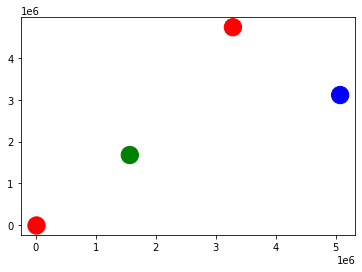

In [10]:
def assign_centroid(gen_data, centroids):
    #Assigning datapoints to the centroid

    n_ob = gen_data.shape[0]
    centroid_assign = []
    centroid_errors = []
    k = centroids.shape[0]


    for i in range(n_ob):

        # Calculate the errror
        errors = np.array([])
        for centroid in range(k):
            error = calculate_error(centroids.iloc[centroid, :2], gen_data.iloc[i,:2])
            errors = np.append(errors, error)

        # Calculate closest centroid & error 
        closest_centroid =  np.where(errors == np.amin(errors))[0].tolist()[0]
        centroid_error = np.amin(errors)

        # Assign values to lists
        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)

    return (centroid_assign,centroid_errors)

gen_data['centroid'], gen_data['error'] = assign_centroid(gen_data.iloc[:,:2] ,centroids)
gen_data[['centroid', 'error']].head()

colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(gen_data.iloc[:,0], gen_data.iloc[:,1],  marker = 'o', c = gen_data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

data_columns = ['RMSD','F1','F2','F3','F4','F5','F6','F7','F8','F9']

centroids = gen_data.groupby('centroid').agg('mean').loc[:,data_columns].reset_index(drop = True)
centroids

plt.scatter(gen_data.iloc[:,0], gen_data.iloc[:,1],  marker = 'o', c = gen_data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))



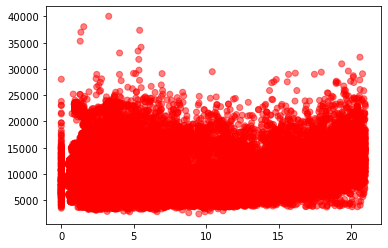

In [11]:
def knn(gen_data, k):
    
    # Initialize centroids and error
    centroids = gen_centroids(k, gen_data)
    error = []
    cond = True
    i = 0

    while(cond):
        # Obtain centroids and error
        gen_data['centroid'], iter_error = assign_centroid(gen_data,centroids)
        error.append(sum(iter_error))
        # Recalculate centroids
        centroids = gen_data.groupby('centroid').agg('mean').reset_index(drop = True)

        # Check if the error has decreased
        if(len(error)<2):
            cond = True
        else:
            if(round(error[i],3) !=  round(error[i-1],3)):
                cond = True
            else:
                cond = False
        i = i + 1 

    gen_data['centroid'], iter_error = assign_centroid(gen_data,centroids)
    centroids = gen_data.groupby('centroid').agg('mean').reset_index(drop = True)
    return (gen_data['centroid'], iter_error, centroids)

gen_data['centroid'], _, centroids =  knn(gen_data.drop(['centroid','error'], axis = 1),3)
gen_data['centroid'].head()

plt.scatter(gen_data.iloc[:,0], gen_data.iloc[:,1],  marker = 'o', c = gen_data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

